<a href="https://colab.research.google.com/github/nikhilkr31/pet-breed-classifier/blob/main/pet-breed-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'

In [2]:

from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [3]:
path.ls()
(path/"images").ls()
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

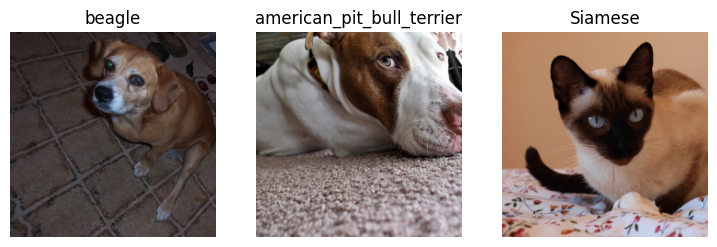

In [4]:
dls.show_batch(nrows=1,ncols=3)

In [5]:
#Fine tuning the model


learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 131MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.503167,0.374419,0.129229,01:15


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,0.523601,0.308086,0.093369,01:11
1,0.323633,0.239504,0.069012,01:12


In [ ]:
# prompt: view activations and labels dataloaders from fastai

learn.show_results(max_n=5)